In [1]:
from nptdms import TdmsFile
import matplotlib.pyplot as plt
import ruptures as rpt
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.cluster.hierarchy as hac
import math
import numpy as np
from random import sample
from scipy.stats import mode


In [102]:
class SegHub(object):

    def segment_and_plot(self, df, model='l1', count=0, n_bkps=5):
        '''
        recieves a segment as input and runs ruptures changeppoint detection algorithm to segment a
        punch into subsequences. Eventually, it plots the segments,
        saves the plot and returns a dataframe containing all segments numbered begining with 1
        '''
        dfs = pd.DataFrame()
        lower_bound = 0
        upper_bound = len(df)

        # change point detection
        #model = "l1"  # "l2", "rbf"

        data = df[lower_bound:upper_bound].values
        algo = rpt.Dynp(model=model, min_size=15, jump=15).fit(data)
        my_bkps_t = algo.predict(n_bkps)

        j = 0
        lower_bound_temp = lower_bound
     
        while j < n_bkps :
            df_temp = pd.DataFrame({j: df[my_bkps_t[j]:my_bkps_t[j+1]]})
            df_temp = df_temp.reset_index(drop=True)
            dfs = pd.concat([dfs, df_temp], axis=1)
            #df[lower_bound_temp:my_bkps_t[j]+lower_bound].plot()
            #lower_bound_temp = my_bkps_t[j]+lower_bound
            j = j + 1
        #plt.savefig('plot_' + model + '_' + str(count) + '.png')
        #plt.clf()
        #print(dfs)
        return dfs

    def extract_hub(self, df_force, df_stroke, start=5000, threshold=0.51):
        '''
        returns data frame containing each punch segment derived by the df_stroke timeseries data
        '''
        dfs = pd.DataFrame()
        flag = False
        begin_temp = 0
        count = 0
        end = 200000#len(df_stroke)
        for i in range(start, end):
            if not(flag) and df_stroke[i] > threshold:
                flag = True
                begin_temp = i
            elif flag and df_stroke[i] > threshold:
                continue
            elif flag and df_stroke[i] < threshold:
                #print(begin_temp,i)
                seg_temp = df_force[begin_temp:i].reset_index(drop=True)
                #seg_temp = (begin_temp, i)
                #segments.append(seg_temp)
                df_temp= pd.DataFrame({count: seg_temp})
                #df_temp = pd.DataFrame(seg_temp)
                #df_temp = df_temp.reset_index(drop=True)
                dfs = pd.concat([dfs,df_temp], axis =1)
                flag = False
                count = count + 1
            else:
                continue
        return dfs


    def plot_all(df_to_plot):
        '''
        plots all columns in the dataframe
        '''
        ax = None
        for index in df_to_plot:
            ax = sns.tsplot(ax=ax, data=df_to_plot[index].values, err_style="unit_traces")
        plt.savefig('test.png')

    def separate_subsequence(df_segments, target_segment):
        dfs = pd.DataFrame()
        
        for j in range(0, len(df_segments)):
            df_temp = pd.DataFrame({j: df_segments[j]})
            df_temp = df_temp.reset_index(drop=True)   
            dfs = pd.concat([dfs, df_temp], axis=1)

    def DTWDistance(self, s1, s2):
        '''
        plots all columns in the dataframe
        '''
        DTW = {}

        for i in range(len(s1)):
            DTW[(i, -1)] = float('inf')
        for i in range(len(s2)):
            DTW[(-1, i)] = float('inf')
        DTW[(-1, -1)] = 0

        for i in range(len(s1)):
            for j in range(len(s2)):
                dist = (s1[i]-s2[j])**2
                DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

        return math.sqrt(DTW[len(s1)-1, len(s2)-1])





# Step 1: Read in data


In [3]:
# load in data, take the TDMS data type as example
tdms_file = TdmsFile(".\\AKF_SS-FW2-H04521-H05000.tdms")
# tdms_file.groups()
df_all = tdms_file.object('Untitled').as_dataframe()
df_force = df_all['Stempel_1 (Formula Result)']
df_stroke = df_all['Position_Ma']


# Step 2: Extract each punch shape

In [103]:
SEH = SegHub()
# Init lists and dfs
segmentation_1 = []
segmentation_2 = []
segmentation_3 = []
segmentation_4 = []
segmentation_5 = []
sub_segmentation = []
# Extract all punches of the dataset
df_punches = SEH.extract_hub(df_force, df_stroke)
#print(df_punches.describe())
df_punches = df_punches.reset_index(drop=True)

# Step 3: separate into subsegmentation

In [104]:
x=0
for i in df_punches:

        # first changepoint detection on whole punch
        # second changepoint detection on 
        punch_seg = SEH.segment_and_plot(df_punches[i].dropna(), 'l2', i)
        #sub_punch_seg = SEH.segment_and_plot(punch_seg[6].dropna(), 'rbf', 7 + i, 4)

        # append to corresponding list
        segmentation_1.append(np.asarray(punch_seg[0]))
        segmentation_2.append(np.asarray(punch_seg[1]))
        segmentation_3.append(np.asarray(punch_seg[2]))
        segmentation_4.append(np.asarray(punch_seg[3]))
        segmentation_5.append(np.asarray(punch_seg[4]))
        #sub_segmentation.append(sub_punch_seg)
        print(punch_seg.shape)
        x = 1+x



(2357, 5)
(2356, 5)
(2341, 5)
(2356, 5)
(2342, 5)
(2341, 5)
(2341, 5)
(2341, 5)
(2340, 5)
(2340, 5)
(2341, 5)
(2340, 5)
(2340, 5)


In [79]:
pd.DataFrame(segmentation_1).to_csv("segmentation_1.csv")
pd.DataFrame(segmentation_2).to_csv("segmentation_2.csv")
pd.DataFrame(segmentation_3).to_csv("segmentation_3.csv")
pd.DataFrame(segmentation_4).to_csv("segmentation_4.csv")
pd.DataFrame(segmentation_5).to_csv("segmentation_5.csv")

##  3.1. save the segmented data and read from date

In [110]:
# sss.tocsv("xxx.csv")
segmentation_1 = pd.read_csv("segmentation_1.csv")
segmentation_2 = pd.read_csv("segmentation_2.csv")
segmentation_3 = pd.read_csv("segmentation_3.csv")
segmentation_4 = pd.read_csv("segmentation_4.csv")
segmentation_5 = pd.read_csv("segmentation_5.csv")

# Step 4. Clustering 
## 4.1 data preparation: uniform the length of segmentation

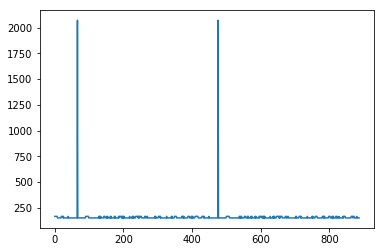

In [223]:
# before uniforming:
# for example: segmentation _1
plt.plot(segmentation_1.count(axis=1))

In [163]:
def Uniformation(Seg, n =478):
    lens = Seg.count(axis=1) # get the number of non-nan length
    len_mnum = mode(lens)[0][0]
    len_min = min(lens)
    rest = Seg.iloc[:,0:len_min]
    if len_mnum == len_min:
        return rest
    else:
        '''
        for the length longerthan the len_mnum, we directly shorten them into mode
        for the length smaller than the len_mnum, we use the interpolate to compansate.
        '''
        rows = np.flatnonzero(lens<len_mnum)
        rest.iloc[rows,0:len_mnum] = rest.iloc[rows,0:len_mnum].interpolate(method='linear',
                                                                            downcast = 'infer',axis = 1 )
        
        
        

In [225]:
data_seg_1= Uniformation(segmentation_1)

## 4.2 sample the data frame

In [228]:
# Randomly sample 80% of your dataframe
df_percent = data_seg_1.sample(frac=0.8)

df_rest = data_seg_1.iloc[~data_seg_1.index.isin(df_percent.index)]


In [229]:
z = hac.linkage(df_percent, 'ward')

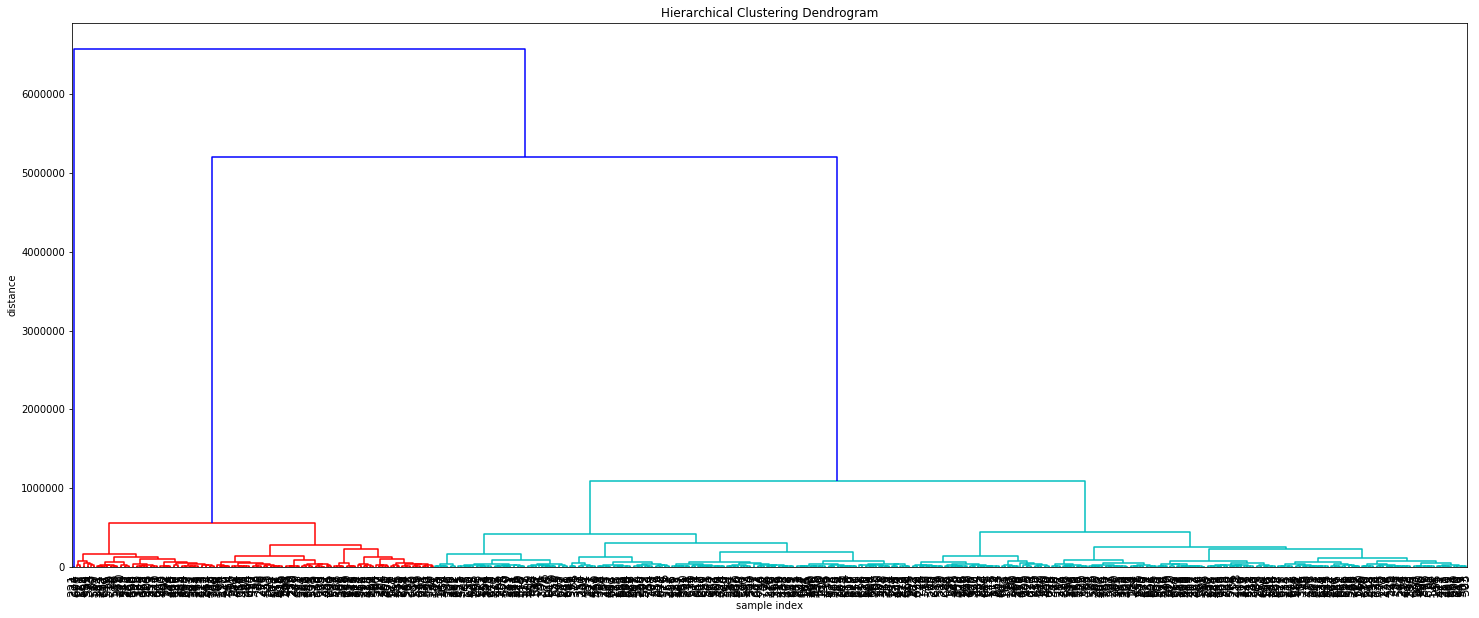

In [230]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
)
plt.show()

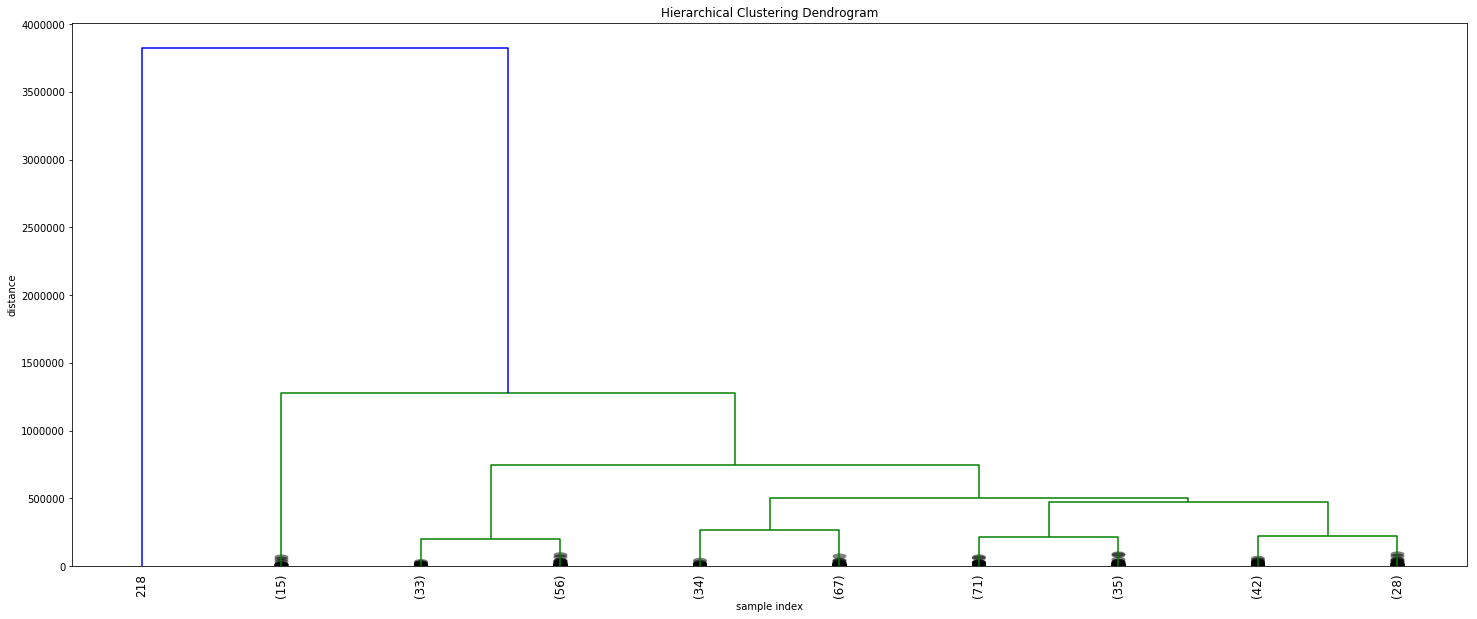

In [72]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    z,
    truncate_mode = 'lastp',
    p = 10,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    show_contracted=True,
)
plt.show()

Cluster 2 number of entries 182


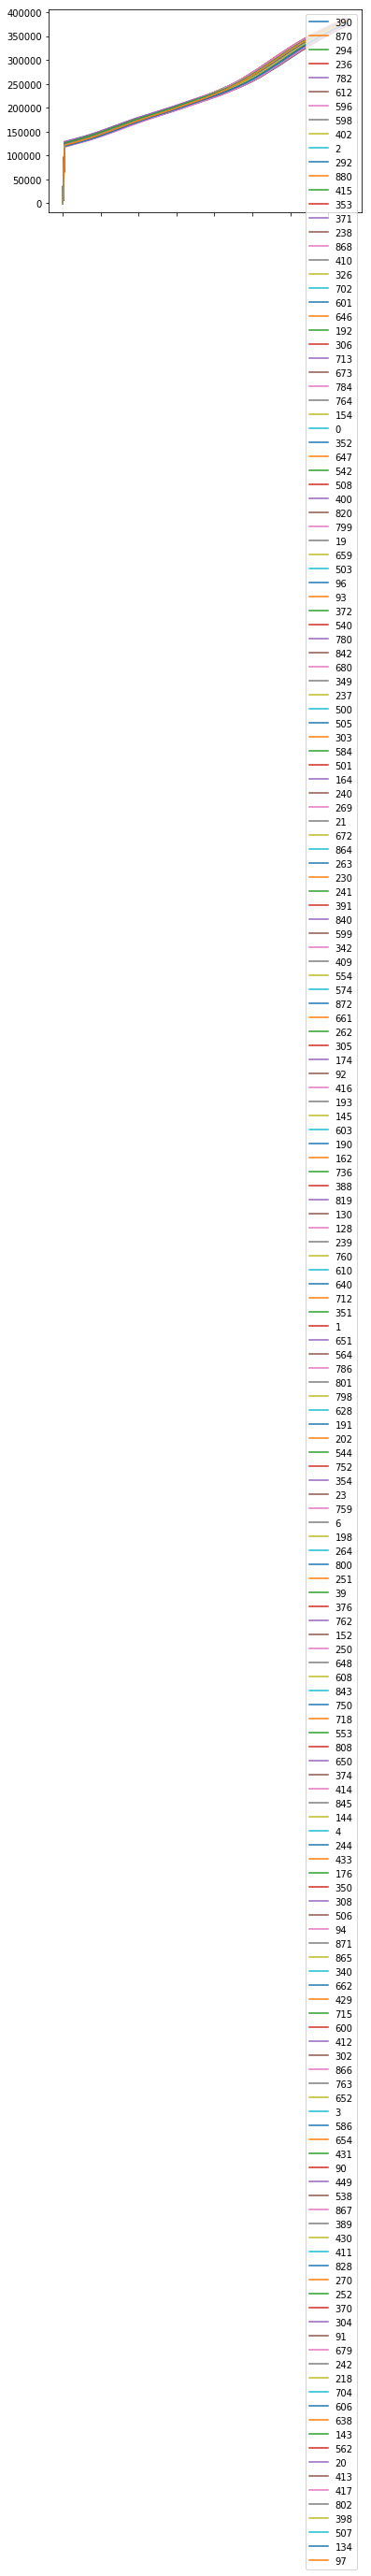

Cluster 3 number of entries 526


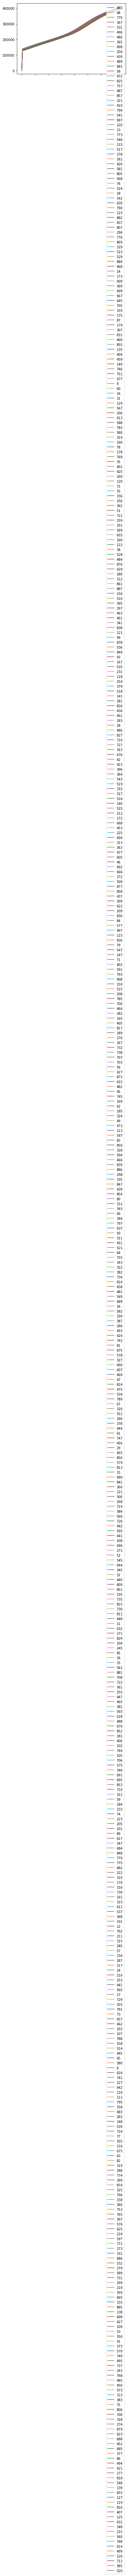

Cluster 1 number of entries 2


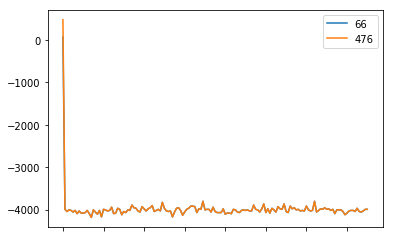

In [231]:
from scipy.cluster.hierarchy import fcluster

def print_clusters(timeSeries, z, k, plot=False):
    # k Number of clusters I'd like to extract
    results = fcluster(z, k, criterion='maxclust')

    # check the results
    s = pd.Series(results)
    clusters = s.unique()

    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
        if len(cluster_indeces)==0:
            continue
        else:
            if plot:
                df_percent.T.iloc[:,cluster_indeces].plot()
                plt.show()
    return results
clusters = print_clusters(segmentation_1, z, 3, plot=True)

Cluster 1 number of entries 0
Cluster 2 number of entries 42


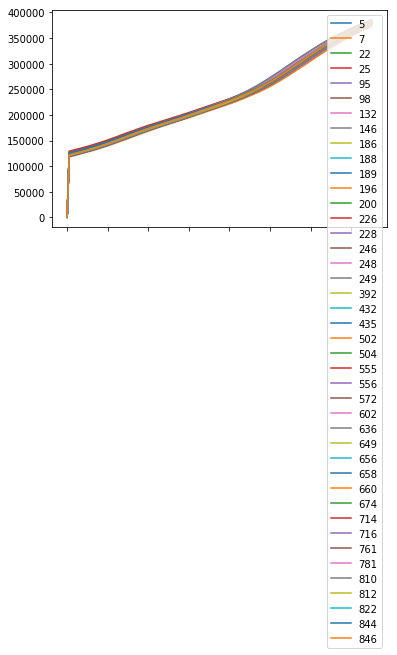

Cluster 3 number of entries 136


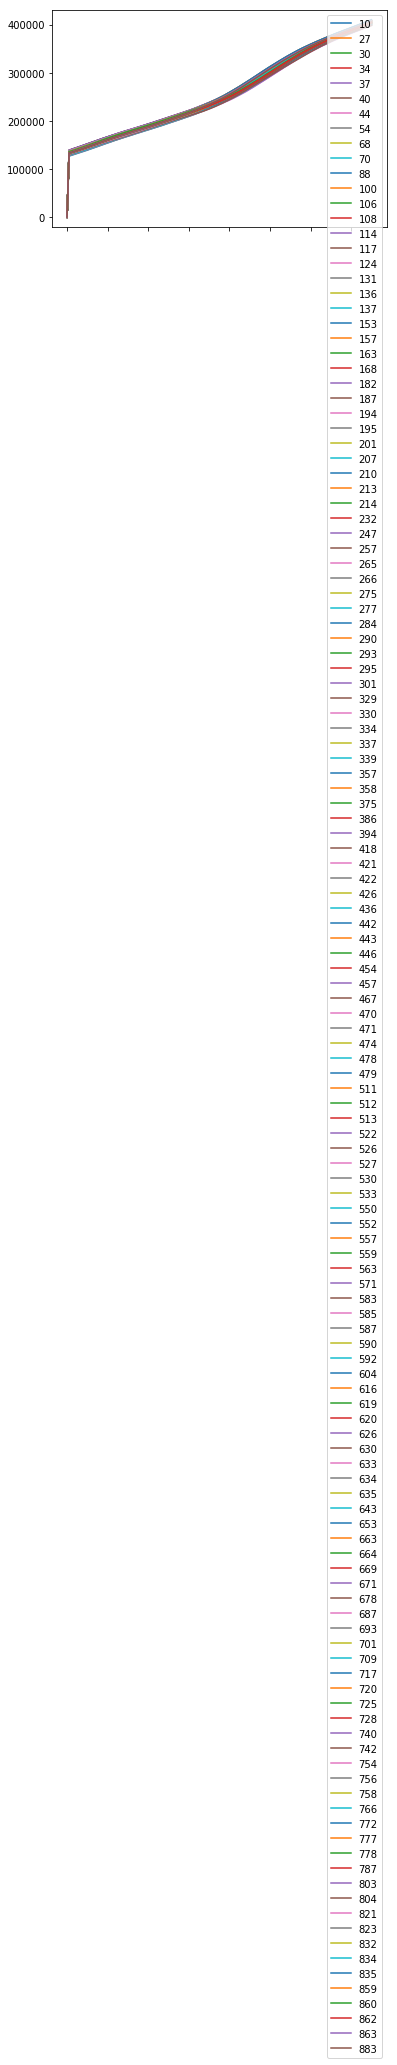

In [241]:
from sklearn.neighbors import KNeighborsClassifier as KNN
neigh = KNN(n_neighbors=3)
neigh.fit(df_percent, clusters) 
clusters2 = neigh.predict(df_rest)

s = pd.Series(clusters2)


for c in [1,2,3]:
    cluster_indeces = s[s==c].index
    print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
    if len(cluster_indeces)==0:
        continue
    df_rest.T.iloc[:,cluster_indeces].plot()
    plt.show()

In [239]:
cluster_indeces = s[s==c].index

In [240]:
cluster_indeces

Int64Index([], dtype='int64')